In [41]:
#importing libraries
import pandas as pd
import numpy as np
import json
import nltk
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
import re
import spacy
import coreferee
from spacy import displacy
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix, f1_score
from transformers import BertTokenizer, BertForQuestionAnswering, logging
import torch
import warnings
warnings.filterwarnings("ignore")

### Data Preprocessing

In [2]:
# Loading news article dataset
news_dataset = 'news_dataset.csv'
news_dataset = pd.read_csv(news_dataset, encoding='latin1')

# text preprocessing to split words stuck together, fix erros where numbers were separated if they had a "," or "." in them (eg. 10.1, 100,000) normalise whitespaces, fix error where ' and " characters are replaced by ?.
for i in range(len(news_dataset)):
    text = news_dataset['article'][i]
    text = re.sub(r'(?<=[a-zA-Z0-9])\?(?=[a-zA-Z0-9])', "'", text)
    text = re.sub(r'(\d+)\.\s+(\d+)', r'\1.\2', text)
    text = re.sub(r'(\d+),\s+(\d+)', r'\1,\2', text)
    text = re.sub(r'(?<![a-z])\?|(?<=\w)\?(?!\s)', '', text)
    text = re.sub(r'^(\s*[A-Z]{2,}\b\s*){1,3}', '', text)
    text = re.sub(r'^,\s*', '', text)
    text = re.sub(r'\s+', ' ', text)
    news_dataset['article'][i] = text

# randomly sampling 100 articles.
dataset = news_dataset.sample(n = 100, random_state = 1, ignore_index = True)
cols = dataset.columns
example_dataset = news_dataset[news_dataset['id'] == 17574].reset_index(drop = True)

In [3]:
dataset.head()

,id,author,date,year,month,topic,article
0,17889,Jan Hoffman,31/01/2017,2017,1,politics,The death rate from cervical cancer in the Uni...
1,18260,Choe Sang-Hun,4/02/2017,2017,2,politics,South Korea The chief of North Korea's powerfu...
2,17823,Alexandra Alter,21/01/2017,2017,1,business,"One night nearly 140 years ago, Samuel Clemens..."
3,17725,Megan Twohey,18/01/2017,2017,1,business,A former contestant on The Apprentice? who acc...
4,17573,Mujib Mashal and Taimoor Shah,12/01/2017,2017,1,crime,Afghanistan Abdul Ali Shamsi had already cover...


In [4]:
example_dataset

,id,author,date,year,month,topic,article
0,17574,Choe Sang-Hun,11/03/2017,2017,3,business,South Korea A special prosecutor investigating...


In [5]:
example_dataset['article'][0]

"South Korea A special prosecutor investigating the corruption scandal that led to President Park s impeachment summoned the de facto head of Samsung for questioning on Wednesday, calling him a bribery suspect. The de facto leader, Jay Y. Lee, the vice chairman of Samsung, will be questioned on Thursday, according to the special prosecutor's office, which recommended that he also be investigated on suspicion of perjury. Mr. Lee effectively runs Samsung, South Korea's largest conglomerate he is the son of its chairman, Lee who has been incapacitated with health problems. He is expected to be asked whether donations that Samsung made to two foundations controlled by Choi a longtime friend of the president, amounted to bribes, and what role, if any, he played in the decision to give the money. Investigators at the special prosecutor's office have questioned other senior Samsung executives as suspects about the bribery accusations. Neither Samsung nor Mr. Lee responded immediately to the a

In [6]:
with open("dev-v2.0.json", 'r') as f: # loading SQuAD 2.0 dev data for training and testing
    squad_data = json.load(f)
    
# getting article context, associated questions and answers
context = []
questions = []
answers = []

for i in squad_data['data']: # extracting above from json file
    for y in i['paragraphs']:
        text = y['context']
        text = re.sub(r'\([^)]*\)', '', text)
        text = re.sub(r'\s+', ' ', text)
        context.append(text)
        context_q = []
        context_a = []
        for x in y['qas']:
            context_q.append(x['question'])
            if 'answers' in x and x['answers']:
                context_a.append([x['answers'][i]['text'] for i in range(len(x['answers']))])
            else:
                context_a.append(None)
        questions.append(context_q)
        answers.append(context_a)

# sampling 10 articles
articles = [context, questions, answers]
df = pd.DataFrame(articles).T
df.columns = ['context', 'questions', 'answers']
squad_articles = df.sample(n = 10, random_state = 1, ignore_index = True)

In [7]:
squad_articles

,context,questions,answers
0,During the divestment from South Africa moveme...,[When was the divestment from South Africa mov...,"[[late 1980s, late 1980s, 1980s], [South Afric..."
1,The 1973 oil crisis began in October 1973 when...,"[When did the 1973 oil crisis begin?, What was...","[[October 1973, October 1973, October 1973, Oc..."
2,There were many religions practiced during the...,"[Which khanates had converted to Islam?, Which...","[[western, Yuan dynasty, western], [Buddhism, ..."
3,To measure the difficulty of solving a computa...,[What is a commonly used measurement used to d...,[[how much time the best algorithm requires to...
4,Other important complexity classes include BPP...,[What are three examples of complexity classes...,"[[BPP, ZPP and RP, BPP, ZPP and RP, BPP, ZPP a..."
5,Packet mode communication may be implemented w...,[In cases of shared physical medium how are th...,[[the packets may be delivered according to a ...
6,"Greater London has over 900,000 Muslims, , and...","[How many Muslims are in Greater London?, What...","[[over 900,000, 900,000, over 900,000], [stron..."
7,British victories continued in all theaters in...,"[Who defeated Montcalm at Quebec?, What was th...","[[James Wolfe, James Wolfe, James Wolfe, James..."
8,While studying law and philosophy in England a...,[What was Iqbal studying in England and German...,"[[law and philosophy, law and philosophy, law ..."
9,Phagocytosis is an important feature of cellul...,[What type of cells engulf or eat pathogens an...,"[[phagocytes, phagocytes, phagocytes], [cytoki..."


In [8]:
squad_articles['context'][0]

'During the divestment from South Africa movement in the late 1980s, student activists erected a symbolic "shantytown" on Harvard Yard and blockaded a speech given by South African Vice Consul Duke Kent-Brown. The Harvard Management Company repeatedly refused to divest, stating that "operating expenses must not be subject to financially unrealistic strictures or carping by the unsophisticated or by special interest groups." However, the university did eventually reduce its South African holdings by $230 million in response to the pressure.'

In [9]:
squad_articles['questions'][0]

['When was the divestment from South Africa movement? ',
 'What South African Vice Consul did Harvard students blockade the speech of? ',
 'By how much did Harvard management reduce its South Africa holdings in response to pressure?',
 'In what year did South African Vice Consul Duke Kent-Brown take office?',
 'What was erected in South Africa by Duke Kent-Brown to protest Harvard?',
 'What did Kent-Brown do to interrupt a speech by Harvard?',
 'What amount of money did Kent-Brown have invested in Harvard?',
 'By how much did Kent-Brown reduce his investment in Harvard?']

In [10]:
squad_articles['answers'][0]

[['late 1980s', 'late 1980s', '1980s'],
 ['South African Vice Consul Duke Kent-Brown.',
  'Duke Kent-Brown',
  'Duke Kent-Brown'],
 ['$230 million', '$230 million', '$230 million'],
 None,
 None,
 None,
 None,
 None]

### Question processing

In [11]:
nlp = spacy.load("en_core_web_sm")

def get_focus_phrases(question):
    doc = nlp(question)
    key_phrases = []
    skip = {"who", "what", "when", "where", "why", "how", "whom", "whose", "whereabouts"}  # Set of words to skip

    for token in doc:
        if token.dep_ in ('nsubj', 'nsubjpass', 'dobj') and token.text.lower() not in skip: # Extract the entire subtree associated with the dependency token
            subtree = token.subtree
            phrase = ' '.join([tok.text for tok in subtree])
            phrase = re.sub(r"\s+'s", "'s", phrase) # Use regex to correctly format possessives by removing any spaces before "'s"
            key_phrases.append(phrase)
    
    if not key_phrases: # small differences in phrasing cause no focus to be noticed so add this just incase none were found
        for noun_chunk in doc.noun_chunks:
            t = False
            for token in noun_chunk:
                if token.text.lower() in skip:
                    t = True
            if not t:
                key_phrases.append(noun_chunk.text)

    return key_phrases

def create_query(question):
    key_phrases = get_focus_phrases(question)
    
    if not key_phrases:  # If no key phrases are found, return None
        return None
    
    valid_phrases = [phrase for phrase in key_phrases if phrase in question] # Filter and check for the presence of key phrases in the question

    if not valid_phrases:  # If no valid phrases are present in question, return None
        return None
    
    earliest_start = min(question.find(phrase) for phrase in valid_phrases) # Find the earliest start index among the valid key phrases in the question
    query = question[earliest_start:] # Create the query from the earliest key phrase found to the end of the question
    query = re.sub(r'\?$', '', query.strip())  # Remove '?' at the end if present
    return query

def ans_type(question): # very basic and rudementary ans_type detection, refrerence [1]
    doc = nlp(question)
    
    question_type = "unknown" # default for if question type isn't detected
    
    # Dict of question type words and corresponding question types
    question_type_dict = { "who": "person", "whom": "person", "whose": "person", "what": "thing", "when": "time", "where": "location", "why": "reason", "how": "method", "whereabouts": "location"}
    
    for token in doc:
        if token.lower_ in question_type_dict: # Lowercaseing for first word
            question_type = question_type_dict[token.lower_]
            break  # Stop searching once the question type is found
    
    return question_type

In [12]:
nlp = spacy.load("en_core_web_sm")
text = 'Who is the vice chairman of Samsung?'
ex_query = create_query(text)
print(ex_query)
ex_ans = ans_type(text)
print(ex_ans)

the vice chairman of Samsung
person


### Coreference resolution

In [13]:
def get_noun_chunk(token, doc): # function to handle if there are multiple noun chunks that contain the same token phrase.
    best_chunk = None
    max_overlap = 0
    token_subtree = set([t.i for t in token.subtree]) 
    for chunk in doc.noun_chunks:
        chunk_indices = set([t.i for t in chunk])
        overlap = len(token_subtree & chunk_indices) # calculates the overlap between the indicies of token tree and the noun chunk
        if overlap > max_overlap:
            max_overlap = overlap
            best_chunk = chunk
    return best_chunk # returns the noun chunk that best matches the token tree

def print_corefs(text):
    nlp = spacy.load("en_core_web_sm")
    nlp.add_pipe('coreferee')
    doc = nlp(text)
    doc._.coref_chains.print()


def resolve_coreference(text): # reference [2]
    nlp = spacy.load("en_core_web_sm")
    nlp.add_pipe('coreferee')
    doc = nlp(text)
    
    text_tomod = []

    for chain in doc._.coref_chains: # each coreference chain
        token_word = None
        
        for index in chain: # select first token in chain that isn't a pronoun
            if doc[index[0]].pos_ != 'PRON':
                token_word = doc[index[0]] # actual token
                break
        if not token_word: # If all tokens are pronouns then skip to next chain
            continue

        noun_chunk = get_noun_chunk(token_word, doc) # Get the phrase that the token belongs to
        noun_chunk_text = noun_chunk.text if noun_chunk else token_word.text

        for index in chain: # Replace only the pronouns in the coreference chain (overlapping of same entities)
            token = doc[index[0]]
            if token.pos_ == 'PRON':
                text_tomod.append((token.idx, token.idx + len(token), noun_chunk_text)) # gets start and end location of pronoun

    text_tomod.sort(reverse=True) # Apply in reverse order to not mess up the indices
    resolved_text = text
    for start, end, replacement in text_tomod:
        resolved_text = resolved_text[:start] + replacement + resolved_text[end:]

    return resolved_text

In [14]:
text = example_dataset['article'][0]
print_corefs(text)
example_coref = resolve_coreference(text)
doc = nlp(example_coref)
ex_text = doc.text
list(doc.sents)

0: Korea(1), Korea(82)
1: head(20), him(29)
2: Samsung(22), Samsung(47), Samsung(79), its(91), Samsung(112), Samsung(169), Samsung(193), Samsung(270), company(289)
3: prosecutor(59), he(66), he(86), He(103), he(138)
4: Lee(76), Lee(94)
5: Park(184), her(215), Park(223), she(231), her(247)
6: Lee(254), he(262), He(276), Lee(312), Lee(329), Lee(365), Lee(389), Lee(403)
7: donations(274), donations(281)
8: office(322), it(324), It(353)
9: president(338), president(351)
10: prosecutors(415), They(440)
11: Choi(418), her(436)
12: Park(443), Park(524), Park(533)
13: businesses(456), businesses(527)
14: all(458), they(463)
15: pressure(467), its(472)
16: Samsung(530), Samsung(542), it(564), Samsung(607), Samsung(669), Samsung(684), its(686), Samsung(768)
17: Choi(549), Choi(585), Choi(603), Choi(623), her(625), Choi(648), she(652), Choi(690)
18: office(637), it(639)
19: merger(705), merger(735)
20: chairman(714), he(727), he(737), his(770)
21: fund(718), fund(731)


[South Korea A special prosecutor investigating the corruption scandal that led to President Park s impeachment summoned the de facto head of Samsung for questioning on Wednesday, calling the de facto head a bribery suspect.,
 The de facto leader, Jay Y. Lee, the vice chairman of Samsung, will be questioned on Thursday, according to the special prosecutor's office, which recommended that the special prosecutor's office also be investigated on suspicion of perjury.,
 Mr. Lee effectively runs Samsung, South Korea's largest conglomerate the special prosecutor's office is the son of Samsung chairman, Lee who has been incapacitated with health problems.,
 the special prosecutor's office is expected to be asked whether donations that Samsung made to two foundations controlled by Choi a longtime friend of the president, amounted to bribes, and what role, if any, the special prosecutor's office played in the decision to give the money.,
 Investigators at the special prosecutor's office have qu

In [15]:
# Apply coreference resolution to each article in dataset and squad_articles
for i in range(len(dataset)):
    original_text = dataset['article'][i]
    resolved_text = resolve_coreference(original_text)
    dataset.at[i, 'article'] = resolved_text
    
for i in range(len(squad_articles)):
    original_text = squad_articles['context'][i]
    resolved_text = resolve_coreference(original_text)
    squad_articles.at[i, 'context'] = resolved_text

In [16]:
text = "the de facto leader, Jay Y. Lee, the vice chairman of Samsung"
doc = nlp(text)
options = {"distance": 100}
displacy.render(doc, options = options, style="dep")

In [17]:
# Noun phrases coreferences. Coreferee pipeline doesn't handle noun phrases well.
# Augmented version used later that gives more leeway for distance
nlp = spacy.load("en_core_web_sm")

def find_entity_relations(doc):
    entities_relations = []

    for ent in doc.ents:
        for right in ent.root.rights: # Look for appositional noun phrases following the entity
            if right.dep_ == 'appos':
                appos_phrase = ' '.join(tok.text_with_ws for tok in right.subtree).strip() # Use the subtree of the apposition to get the full noun phrase
                entities_relations.append((ent, appos_phrase, 'Appos'))

        if ent.root.dep_ == 'appos': # Look for noun phrases that the entity is appositional to
            head_of_ent = ent.root.head
            appos_phrase = get_noun_chunk(head_of_ent, doc) # get noun chunk that root head belongs to
            if appos_phrase and appos_phrase.text != ent.text:
                entities_relations.append((ent, appos_phrase.text, 'Appos to'))

    return entities_relations

text = example_coref
doc = nlp(text)

relations = find_entity_relations(doc)

for ent, np, relation_type in relations:
    print(f"Entity: {ent.text}, Related NP: {np}, Type: {relation_type}")

Entity: South Korea, Related NP: A  special  prosecutor  investigating  the  corruption  scandal  that  led  to  President  Park  s  impeachment, Type: Appos
Entity: Jay Y. Lee, Related NP: the  vice  chairman  of  Samsung, Type: Appos
Entity: Jay Y. Lee, Related NP: The de facto leader, Type: Appos to
Entity: Samsung, Related NP: South  Korea 's  largest  conglomerate, Type: Appos
Entity: Lee, Related NP: the son, Type: Appos to
Entity: Choi, Related NP: two  foundations, Type: Appos
Entity: Samsung, Related NP: the businesses, Type: Appos to


### Passsage Retrieval

In [18]:
def find_most_relevant_article(query, dataset):
    nlp = spacy.load('en_core_web_sm')
    dataset_info = True
    
    query_ = nlp(query)
    words = [token.text for token in query_]
    stop_words = set(stopwords.words('english'))
    query = ' '.join([word for word in words if word.lower() not in stop_words]) # removing stopwords from query
    
    if 'context' in dataset.columns: # for if it is the squad dataset
        articles = dataset['context'].values
        dataset_info = False
    else:
        articles = dataset['article'].values
    
    query_length = len([token for token in nlp(query)])
    if query_length > 2:
        vectorizer = TfidfVectorizer(ngram_range=(1, 3)) # Use unigrams, bigrams, and trigrams for longer querys. Longer n-grams take too long to compute.
    else:
        vectorizer = TfidfVectorizer(ngram_range=(1, 2)) # Use unigrams and bigrams for shorter querys
    
    doc_query = [query] + list(articles) # Vectorize both the query and all articles
    tfidf_matrix = vectorizer.fit_transform(doc_query)
    
    cosine_similarities = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:]).flatten() # Calculate cosine similarity between the query and each article and sort them
    df = pd.DataFrame(dataset)
    df['cosine'] = cosine_similarities
    df = df.sort_values(by=['cosine'], ascending=False).reset_index(drop=True)
    
    if dataset_info is True:
        return df.iloc[0], True
    else:
        return df.iloc[0]['context'], False
    

In [19]:
target = find_most_relevant_article('Who embrased her signature role?', dataset)
target

(id                                                     17945
 author                                          Jeremy Egner
 date                                              26/01/2017
 year                                                    2017
 month                                                      1
 topic                                                  crime
 article    Mary Tyler Moore, who died on Wednesday at 80,...
 cosine                                              0.015998
 Name: 0, dtype: object,
 True)

In [33]:
target[0]['id']

17945

In [20]:
def find_most_relevant_sentence(text, query):
    nlp = spacy.load('en_core_web_sm')
    doc = nlp(text)

    sentences = [sent.text.strip() for sent in doc.sents] # Extract sentences from the document

    query_length = len([token for token in nlp(query)]) # get query length and if > 2 use uni, bi, and trigrams else just uni and bi
    if query_length > 2:
        vectorizer = TfidfVectorizer(ngram_range=(1, 3))
    else:
        vectorizer = TfidfVectorizer(ngram_range=(1, 2))

    doc_query = [query] + sentences
    tfidf = vectorizer.fit_transform(doc_query) # get tfidf matrix
    cosine_similarities = cosine_similarity(tfidf[0:1], tfidf[1:]).flatten() # cosine similarity calculation for each sentence with query
    
    df = pd.DataFrame(sentences)
    df.columns = ['sentence']
    df['cosine'] = cosine_similarities
    df = df.sort_values(by = ['cosine'], ascending = False)
    return list(df['sentence'].values), list(df['cosine'])

In [21]:
sents, cos = find_most_relevant_sentence(ex_text, ex_query)

In [22]:
for i in range(len(sents[:3])):
    print(f"Sent {i+1}: {sents[i]}")
    print(f"Cos {i+1}: {cos[i]}")

Sent 1: The de facto leader, Jay Y. Lee, the vice chairman of Samsung, will be questioned on Thursday, according to the special prosecutor's office, which recommended that the special prosecutor's office also be investigated on suspicion of perjury.
Cos 1: 0.3046674865863344
Sent 2: Mr. Lee effectively runs Samsung, South Korea's largest conglomerate the special prosecutor's office is the son of Samsung chairman, Lee who has been incapacitated with health problems.
Cos 2: 0.08350800612409177
Sent 3: Moon chairman of the pension fund, was arrested last month on charges that the pension fund illegally pressured the fund to back that merger when the pension fund was South Korea's health and welfare minister.
Cos 3: 0.0632450568712193


### Answer Extraction

In [23]:
def extract_answer(question, context, ans_type):
    doc = nlp(context)
    question_doc = nlp(question)
    ans_type = ans_type.lower()

    # Generate all possible n-grams from the question
    question_ngrams = [' '.join(token.text for token in question_doc[i:j]) for i in range(len(question_doc)) for j in range(i+1, len(question_doc)+1)] 

    ngram_lengths = {ngram: len(ngram) for ngram in question_ngrams} # Map n-grams to their lengths

    largest_ngram = '' 
    largest_ngram_length = 0
    ngram_chunk_pos = None
    for chunk in doc.noun_chunks: # Check which n-grams are in noun chunks and find the longest one
        for ngram in question_ngrams:
            if ngram in chunk.text and ngram_lengths[ngram] > largest_ngram_length:
                largest_ngram = ngram
                largest_ngram_length = ngram_lengths[ngram]
                ngram_chunk_pos = chunk  # The span of the noun chunk containing the largest ngram
    
    if ngram_chunk_pos == None: # if not in text then return none
        return None
    
    candidate_chunks = []
    for chunk in doc.noun_chunks:
        if abs(chunk.start - ngram_chunk_pos.end) <= 4 or abs(chunk.end - ngram_chunk_pos.start) <= 4: # checking that the appositinal noun phrases are within 4 tokens
            candidate_chunks.append(chunk.text)
            
    cands = []
    for i in candidate_chunks: # checking that there is no overlap between the focus and the noun phrases
        if i not in [y.text for y in question_doc.noun_chunks]:
            cands.append(i)
            
    if not cands: # if no nooun phrases return none
        return None
            
    candidate_ans = []
    foun_ent_ans = []
    
    
    for chunk in cands: # Refine potential answers by matching ans_type with entity type
        doc_chunk = nlp(chunk)
        if not doc_chunk.ents:
            candidate_ans.append(chunk)
            continue
        for ent in doc_chunk.ents:
            if ans_type == "person" and ent.label_ in ["PERSON", "ORG", "NORP"]:
                foun_ent_ans.append(ent.text)
            elif ans_type == "time" and ent.label_ in ["DATE", "TIME"]:
                foun_ent_ans.append(ent.text)
            elif ans_type == "location" and ent.label_ in ["GPE", "LOC"]:
                foun_ent_ans.append(ent.text)
    
    if ans_type in ["person", "time", "location"]: # if no entity found in that answer type, return none
        if not foun_ent_ans:
            return None
    
    foun_ent_ans.extend(candidate_ans) # extend other noun phrases to list
    
    if not foun_ent_ans: # if no answers then return none
        return None
    
    return foun_ent_ans

In [55]:
# pre-trained BERT model for question answering
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
logging.set_verbosity_error()

def bert_qa_system(question, context):
    inputs = tokenizer.encode_plus(question, context, add_special_tokens=True, return_tensors="pt", max_length=512, truncation=True)
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    answer_start_scores = outputs.start_logits
    answer_end_scores = outputs.end_logits
    # Get the beginning and end indices of the answer
    answer_start = torch.argmax(answer_start_scores)
    answer_end = torch.argmax(answer_end_scores) + 1
    # Convert token IDs to tokens and then join them into a string
    input_ids_list = input_ids.tolist()[0]
    answer_tokens = tokenizer.convert_ids_to_tokens(input_ids_list[answer_start:answer_end])
    answer = tokenizer.convert_tokens_to_string(answer_tokens)
    
    if not answer.strip():
        return None
    
    return answer

In [45]:
question = "Who is the vice chairman of Samsung?"
context = example_dataset['article'][0]  # Example context from the dataset
answer = bert_qa_system(question, context)
print(answer)

jay y . lee


### Test Harness

In [47]:
def get_res(model_answers, true_answers): # method cycles through model answers and checks whether they are in the true answers or a substring of them.
    if model_answers is None or true_answers is None:
        return model_answers == true_answers
    
    model_answers = [ans.lower() for ans in model_answers]
    true_answers = [ans.lower() for ans in true_answers]
    
    for i in model_answers: # check if a model answer is a substring of a true answer
        for y in true_answers:
            if i in y:
                return True
    
    for y in true_answers: # check if a true answer is a substring of a model answer
        for i in model_answers:
            if y in i:
                return True
        
    return False

In [67]:
def test_normal_model():
    results = []
    true = []  # List for actual labels
    pred = []  # List for model predictions
    
    for i in range(len(squad_articles['questions'])):  # For each set of questions in the dataset
        for y in range(len(squad_articles['questions'][i])):
            question = squad_articles['questions'][i][y]
            print(f"Question: {question}")
            answers = squad_articles['answers'][i][y]
            
            query = create_query(question)  # Create query from the question
            if query is None:  # Error handling for empty query
                if answers is None:
                    true.append(0)  # No answer expected (None = 0)
                else:
                    true.append(1)  # Answer expected (not None = 1)
                
                pred.append(0)  # No prediction made
                
                print(f"\tCorrect Possible Ans: {answers}\n\tModel Candidate Ans: None\n\tMatch?: False")
                continue
            
            # Find the most relevant article based on the query
            relevant_article, _ = find_most_relevant_article(query, squad_articles)
            if _ is True:
                article_context = relevant_article['article']  # Testing two dataset formats
            else:
                article_context = relevant_article

            # Determine the type of answer expected
            answer_type = ans_type(question)
            
            # Find the most relevant sentence from the resolved article context
            sents, cos = find_most_relevant_sentence(article_context, query)
            
            # Extract answer from the most relevant sentence
            ans = extract_answer(query, sents[0], answer_type)

            if answers is None:  # If no correct answer is provided
                true.append(0)  # No answer expected (None = 0)
                
                if ans is None:  # Model correctly provides no answer
                    pred.append(0)  # True Negative (TN)
                    res = True
                else:  # Model incorrectly provides an answer
                    pred.append(1)  # False Positive (FP)
                    res = False
            else:  # If a correct answer is provided
                true.append(1)  # Answer expected (not None = 1)
                
                if get_res(ans, answers):  # Model answer matches
                    pred.append(1)  # True Positive (TP)
                    res = True
                else:  # Model answer does not match
                    pred.append(0)  # False Negative (FN)
                    res = False
            
            results.append(res)
            
            # Print possible answers, candidate answers, and whether they match
            print(f"\tCorrect Possible Ans: {answers}")
            print(f"\tModel Candidate Ans: {ans}\n\tMatch?: {res}")
    
    # Confusion matrix and F1 score for normal model
    cm = confusion_matrix(true, pred)
    f1 = f1_score(true, pred)
    print("Confusion Matrix (Normal Model):")
    print(cm)
    print("F1 Score (Normal Model):", f1)

    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.5)  # for label size
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix (Normal Model)')
    plt.show()
    
    return

Question: When was the divestment from South Africa movement? 
	Correct Possible Ans: ['late 1980s', 'late 1980s', '1980s']
	Model Candidate Ans: ['the late 1980s']
	Match?: True
Question: What South African Vice Consul did Harvard students blockade the speech of? 
	Correct Possible Ans: ['South African Vice Consul Duke Kent-Brown.', 'Duke Kent-Brown', 'Duke Kent-Brown']
	Model Candidate Ans: ['a speech']
	Match?: False
Question: By how much did Harvard management reduce its South Africa holdings in response to pressure?
	Correct Possible Ans: ['$230 million', '$230 million', '$230 million']
	Model Candidate Ans: ['the university']
	Match?: False
Question: In what year did South African Vice Consul Duke Kent-Brown take office?
	Correct Possible Ans: None
	Model Candidate Ans: None
	Match?: True
Question: What was erected in South Africa by Duke Kent-Brown to protest Harvard?
	Correct Possible Ans: None
	Model Candidate Ans: ['a symbolic "shantytown', 'a speech']
	Match?: False
Question

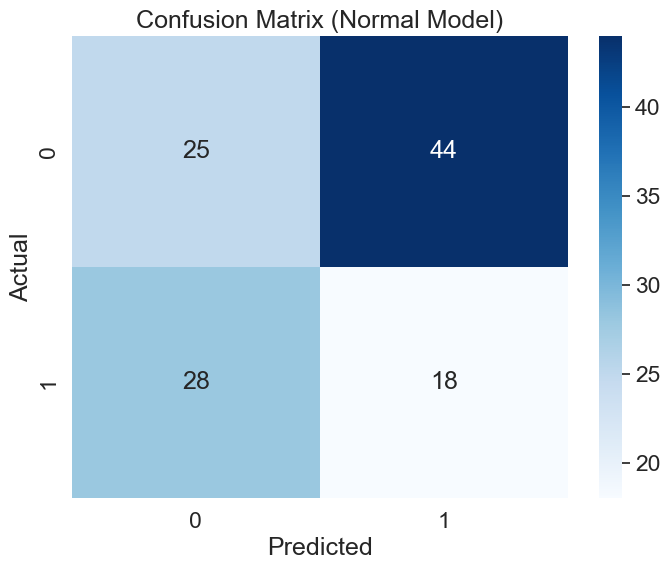

In [68]:
test_normal_model()

In [63]:
def test_bert_model():
    bert_results = []
    true = []  # List for actual labels
    bert_pred = []  # List for BERT model predictions
    
    for i in range(len(squad_articles['questions'])):  # For each set of questions in the dataset
        for y in range(len(squad_articles['questions'][i])):
            question = squad_articles['questions'][i][y]
            print(f"Question: {question}")
            answers = squad_articles['answers'][i][y]
            
            query = create_query(question)  # Create query from the question
            if query is None:  # Error handling for empty query
                if answers is None:
                    true.append(0)  # No answer expected (None = 0)
                else:
                    true.append(1)  # Answer expected (not None = 1)
                
                bert_pred.append(0)  # No prediction made
                
                print(f"\tCorrect Possible Ans: {answers}\n\tBERT Candidate Ans: None\n\tMatch?: False")
                continue
            
            # Find the most relevant article based on the query
            relevant_article, _ = find_most_relevant_article(query, squad_articles)
            if _ is True:
                article_context = relevant_article['article']  # Testing two dataset formats
            else:
                article_context = relevant_article

            # Find the most relevant sentence from the resolved article context
            sents, cos = find_most_relevant_sentence(article_context, query)
            
            # Extract answer from the most relevant sentence using BERT
            bert_ans = bert_qa_system(query, sents[0])

            if answers is None:  # If no correct answer is provided
                true.append(0)  # No answer expected (None = 0)
                
                if bert_ans is None or bert_ans.strip() == "":  # BERT correctly provides no answer
                    bert_pred.append(0)  # True Negative (TN)
                    bert_res = True
                else:  # BERT incorrectly provides an answer
                    bert_pred.append(1)  # False Positive (FP)
                    bert_res = False
            else:  # If a correct answer is provided
                true.append(1)  # Answer expected (not None = 1)
                
                if get_res(bert_ans, answers):  # BERT answer matches
                    bert_pred.append(1)  # True Positive (TP)
                    bert_res = True
                else:  # BERT answer does not match
                    bert_pred.append(0)  # False Negative (FN)
                    bert_res = False
            
            bert_results.append(bert_res)
            
            # Print possible answers, BERT candidate answers, and whether they match
            print(f"\tCorrect Possible Ans: {answers}")
            print(f"\tBERT Candidate Ans: {bert_ans}\n\tMatch?: {bert_res}")
    
    # Confusion matrix and F1 score for BERT model
    cm = confusion_matrix(true, bert_pred)
    f1 = f1_score(true, bert_pred)
    print("Confusion Matrix (BERT Model):")
    print(cm)
    print("F1 Score (BERT Model):", f1)

    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.5)  # for label size
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix (BERT Model)')
    plt.show()
    
    return

Question: When was the divestment from South Africa movement? 
	Correct Possible Ans: ['late 1980s', 'late 1980s', '1980s']
	BERT Candidate Ans: in the late 1980s , student activists erected a symbolic " shantytown " on harvard yard
	Match?: True
Question: What South African Vice Consul did Harvard students blockade the speech of? 
	Correct Possible Ans: ['South African Vice Consul Duke Kent-Brown.', 'Duke Kent-Brown', 'Duke Kent-Brown']
	BERT Candidate Ans: duke kent - brown
	Match?: True
Question: By how much did Harvard management reduce its South Africa holdings in response to pressure?
	Correct Possible Ans: ['$230 million', '$230 million', '$230 million']
	BERT Candidate Ans: $ 230 million
	Match?: True
Question: In what year did South African Vice Consul Duke Kent-Brown take office?
	Correct Possible Ans: None
	BERT Candidate Ans: None
	Match?: True
Question: What was erected in South Africa by Duke Kent-Brown to protest Harvard?
	Correct Possible Ans: None
	BERT Candidate Ans: 

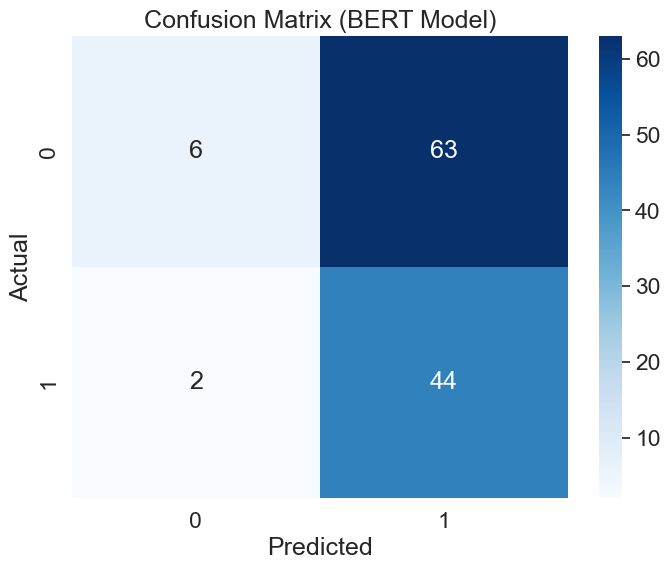

In [64]:
test_bert_model()

### Q and A System

In [44]:
dataset.tail()

,id,author,date,year,month,topic,article
95,18069,Cara Buckley,31/01/2017,2017,1,entertainment,Any doubts that Hollywood would take sharp aim...
96,17945,Jeremy Egner,26/01/2017,2017,1,crime,"Mary Tyler Moore, who died on Wednesday at 80,..."
97,17983,Chris Buckley and Adam Wu,27/01/2017,2017,1,business,Xu Zhengming was lugging a television through ...
98,17591,"Scott Shane, Nicholas Confessore and Matthew R...",6/02/2017,2017,2,politics,"Seven months ago, a respected former British s..."
99,17473,Daniel Victor,9/01/2017,2017,1,entertainment,Let's just be very clear about this: There is ...


In [35]:
# Modified qa_system function
def qa_system():
    try:
        print("What is your question?")
        question = input("\tQuestion: ")
        print("Analysing Question...")
        
        query = create_query(question)
        if query is None:
            print("Not Viable Question, Exiting...") # Exiting if no noun-chunks are found in the document that aren't question type words
            return
        answer_type = ans_type(question)
        # Find the most relevant article based on the question
        print("Finding relevant article...")
        relevant_article = find_most_relevant_article(query, dataset)
        article_text = relevant_article[0]['article']
        article_id = relevant_article[0]['id']
        author = relevant_article[0]['author']
        date = relevant_article[0]['date']
        topic = relevant_article[0]['topic']
        print(f"\tMost Relevant Article Found - ID: {article_id}, Author: {author}, Date: {date}, Topic: {topic}")
        
        print("Would you like to print off the text?")
        user_input = input("\t(yes/no): ")
        if user_input == "yes":
            print(f"\n\t{article_text}\n")


        print("Finding relevant sentence...")
        sents, cos = find_most_relevant_sentence(article_text, query)
        
        print("Finding answer...")
        ans = extract_answer(query, sents[0], answer_type)
        if ans is None:
            print("\tNo answer Found")
        else:
            for i in range(len(ans)):
                if i == 0:
                    print(f"\tAnswer: {ans[i]}")
                else:
                    print(f"\t\tPossible Answer: {ans[i]}")
        
        print("Exiting now...")
        return
    except KeyError:
        print("Error... Exiting...")
        return

In [37]:
qa_system()

What is your question?
Analysing Question...
Finding relevant article...
	Most Relevant Article Found - ID: 17945, Author: Jeremy Egner, Date: 26/01/2017, Topic: crime
Would you like to print off the text?

	Mary Tyler Moore, who died on Wednesday at 80, had a career in show business. But Mary Tyler Moore is most remembered for two indelible sitcom roles: Laura Petrie on The Dick Van Dyke Show? and later, Mary Richards on The Mary Tyler Moore Show. [ Read Mary Tyler Moore's obituary | 5 great episodes to stream ] Ms. Moore first appeared in The New York Times in 1962, during the first season of The Dick Van Dyke Show, which ran from 1961 to 1966. A reporter interviewed Ms. Moore during a brief trip to New York to CBS executives and affiliates. (When CBS executives saw Mary, there was quite a bit of applause and a few whistles, a network spokesman said.) By 1965 the show was a hit and Ms. Moore was a star. The writer Joanne Stang called Joanne Stang the virtually uncontested popularity 

In [45]:
def qa_system(): # The implementaiton of the QA system
    try:
        print("What is the ID of the article you are searching for?")
        user_input = input("\tArticle ID: ") # getting article
        article = dataset[dataset['id'] == int(user_input)].reset_index(drop = True)
        article_text = article['article'][0]
        if article.empty:
            print("\tArticle Not Found...")
            return # ends the function if the article isn't found
        print("\tArticle Found")
        print(f"\tArticle Information - ID: {article['id'][0]}, Author: {article['author'][0]}, Date: {article['date'][0]}, Topic: {article['topic'][0]}")
        
        print("Would you like to print off the text?")
        user_input = input("\t(yes/no): ")
        if user_input == "yes":
            print(f"\n\t{article_text}\n")
        
        print("What is your question?") # Getting question
        question = input("\tQuestion: ")
        print("Analysing Question...")
        #nlp = spacy.load("en_core_web_sm")
        query = create_query(question)
        if query is None:
            print("Not Viable Question, Exiting...") # Exiting if no noun-chunks are found in the document that aren't question type words
            return
        answer_type = ans_type(question)
        
        article_resolved = resolve_coreference(article_text) # executing coreference resolution
        
        # Finding relevent passage
        print("Finding relevant sentence...")
        sents, cos = find_most_relevant_sentence(article_resolved, query)
        
        # Finding Answer
        print("Finding answer...")
        ans = extract_answer(query, sents[0], answer_type)
        if ans is None:
            print("\tNo answer Found")
        else:
            for i in range(len(ans)):
                if i == 0:
                    print(f"\tAnswer: {ans[i]}")
                else:
                    print(f"\t\tPossible Answer: {ans[i]}")
        
        print("Exiting now...")
        return
        #return answer
    except KeyError:
        print("Error... Exiting...")
        return
    #return answer

In [ ]:
qa_system()

In [28]:
qa_system()

What is the ID of the article you are searching for?


	Article ID:  17945


	Article Found
	Article Information - ID: 17945, Author: Jeremy Egner, Date: 26/01/2017, Topic: crime
Would you like to print off the text?


	(yes/no):  yes



	Mary Tyler Moore, who died on Wednesday at 80, had a career in show business. But she is most remembered for two indelible sitcom roles: Laura Petrie on The Dick Van Dyke Show? and later, Mary Richards on The Mary Tyler Moore Show. [ Read Mary Tyler Moore's obituary | 5 great episodes to stream ] Ms. Moore first appeared in The New York Times in 1962, during the first season of The Dick Van Dyke Show, which ran from 1961 to 1966. A reporter interviewed her during a brief trip to New York to CBS executives and affiliates. (When they saw Mary, there was quite a bit of applause and a few whistles, a network spokesman said.) By 1965 the show was a hit and Ms. Moore was a star. The writer Joanne Stang called her the virtually uncontested popularity queen of weekly television, marveling that Ms. Moore has made housewifery a highly palatable pastime. I guess they simply like me, Ms. Moore said in the article. At the time she was preparing to try to leverage her TV success into a film career

	Question:  Who embrased her signature role?


Analysing Question...
Finding relevant sentence...
Finding answer...
	Answer: Moore
		Possible Answer: Moore
		Possible Answer: lighthearted reunion specials
Exiting now...


In [31]:
qa_system()

What is the ID of the article you are searching for?


	Article ID:  17591


	Article Found
	Article Information - ID: 17591, Author: Scott Shane, Nicholas Confessore and Matthew Rosenberg, Date: 6/02/2017, Topic: politics
Would you like to print off the text?


	(yes/no):  no


What is your question?


	Question:  What began in September 2015?


Analysing Question...
Finding relevant sentence...
Finding answer...
	Answer: The story
Exiting now...


# References

[1] Jurafsky, D. and Martin, J.H. (2014) Speech and language processing. Harlow: Pearson Education Limited.
[2] Hudson, R. and Soumah, V.-G. (2022) MSG-systems/coreferee: Coreference resolution for English, French, German and Polish, optimised for limited training data and easily extensible for further languages, GitHub. Available at: https://github.com/msg-systems/coreferee (Accessed: 15 April 2024).